### Team members

1. Amirhossein Soltani
2. Moein Taherkhani

In [60]:
import numpy as np
import os
import torch
import torch.nn as nn
import yaml
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter


### Downloading the dataset


In [61]:

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


### Dataset inspection

In [62]:
print(f"# Images Train: {len(train_dataset)}")
print(f"# Images Test:  {len(test_dataset)}")

# Images Train: 50000
# Images Test:  10000


In [63]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


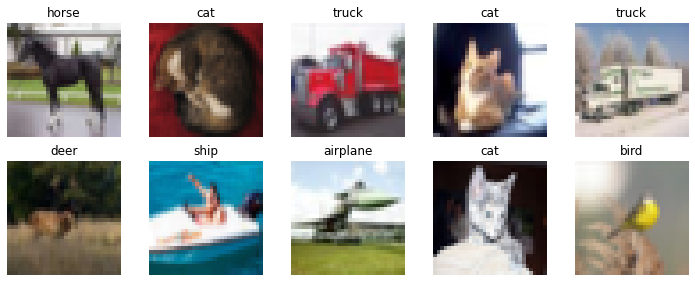

In [64]:
import matplotlib.pyplot as plt


classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

N_IMGS = 8
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 4)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i in range(2):
    for j in range (5):
        id = np.random.randint(0,len(train_dataset),1)[0]
        img = train_dataset[id][0].numpy().transpose((1,2,0))
        ax[i,j].imshow(img)
        ax[i,j].set_title(f"{classes[train_dataset[id][1]]}")
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()


In [65]:
# Spliting the training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### Dataloaders

In [66]:
training_config = {'BATCH_SIZE' : 1024,
                   'lr' : 1e-4,
                   'epochs' : 100,
                   'Experiment_name': 'Exp2'
                   }


train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=True
    )

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=False
)

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=False,
        drop_last=True
    )

## MLP

In [67]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=3072, hidden_dim=512, output_dim=len(classes)):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


In [68]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model = Model().to(device)

summary(mlp_model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                   [-1, 10]           5,130
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 7.02
Estimated Total Size (MB): 7.05
----------------------------------------------------------------


In [69]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=training_config['lr'])

In [70]:
# Checkpoints directory
root = Path("./")
Experiment = training_config['Experiment_name']
save_dir = root/'models'/Experiment
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

# Save the training configuration for each experiment
with open(os.path.join(save_dir, "training_config.yaml"), "w") as f:
    yaml.dump(training_config, f)


In [71]:
log_dict = {'Training_loss' : [] ,'Validation_loss' : [] }

# Tensorboard log directory
log_dir = root/'log_dir'
log_dir = os.path.join(log_dir, Experiment)

# Initialize TensorBoard
writer = SummaryWriter(log_dir=log_dir)  

print("##### TRAINING ... ####")
for epoch in range(training_config['epochs']):
    mlp_model.train()
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        loss = criterion(preds, labels)
        log_dict['Training_loss'].append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Batch {i + 1}: loss {loss.item():.5f}. ")

    writer.add_scalar('Loss/train', loss.item(), epoch)

    # Validation every 5 epochs
    if (epoch + 1) % 20 == 0:
        mlp_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_imgs, val_labels in val_loader:
                val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
                flattened_val_imgs = val_imgs.flatten(start_dim=1)
                val_preds = mlp_model(flattened_val_imgs)
                val_loss += criterion(val_preds, val_labels).item()
        
        avg_val_loss = val_loss / len(eval_loader)
        log_dict['Validation_loss'].append(avg_val_loss)
        print(f"\nValidation loss after epoch {epoch + 1}: {avg_val_loss:.5f}")
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    

writer.close()


##### TRAINING ... ####


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 Batch 40: loss 1.21030. : 100%|██████████| 40/40 [00:01<00:00, 28.41it/s]



Validation loss after epoch 20: 1.69392


Epoch 40 Batch 40: loss 1.57761. : 100%|██████████| 40/40 [00:01<00:00, 27.98it/s]



Validation loss after epoch 40: 1.57477


Epoch 60 Batch 40: loss 1.01700. : 100%|██████████| 40/40 [00:01<00:00, 28.42it/s]



Validation loss after epoch 60: 1.50950


Epoch 80 Batch 40: loss 1.04742. : 100%|██████████| 40/40 [00:01<00:00, 27.77it/s]



Validation loss after epoch 80: 1.48871


Epoch 100 Batch 40: loss 0.93540. : 100%|██████████| 40/40 [00:01<00:00, 28.71it/s]



Validation loss after epoch 100: 1.47637


### EVALUATION

In [74]:

print("##### EVALUATION ... ####")
mlp_model.eval()
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        imgs, labels = imgs.to(device), labels.to(device)

        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%") 

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 27.31it/s]

Test accuracy: 48.97%


### Saving the model

In [73]:
if(not os.path.exists("models")):
    os.makedirs("models",exist_ok=True)
savepath = f"models/checkpoint_{training_config['Experiment_name']}.pth"

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, savepath)

### Convolutional Neural Networks

In [1]:
class CNNModel(nn.Module):

    ''' 
    Inspired by https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch
    '''
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, x):
        return self.network(x)

NameError: name 'nn' is not defined